In [1]:
import os 
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import cutde.fullspace as FS
from scipy.spatial.transform import Rotation as R
from scipy.linalg import svd
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import pchip_interpolate, interp1d
from scipy.signal import resample, detrend, resample_poly
from operator import itemgetter
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [2]:
wellcols=np.arange(12)
WellGeom=pd.read_excel('/home/spri902/Collab_metadata/Well_Points.xlsx',header=0,usecols=wellcols)
WellGeom.columns = WellGeom.columns.str.replace(' ','')
WellGeom.x = WellGeom.x/3.28084
WellGeom.y = WellGeom.y/3.28084
WellGeom.z = WellGeom.z/3.28084

mwells=[]
wellList = ['E1-OB','E1-OT','E1-PDT','E1-PDB','E1-PST','E1-PSB']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    mwells.append(tmpwell)
mwells = pd.concat(mwells)

swells=[]
wellList = ['E1-I','E1-P']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    swells.append(tmpwell)
swells = pd.concat(swells)

# map DAS channel data to actual well coordinates
PDTchans = np.r_[1271:1388]
PDBchans = np.r_[1091:1210]
PDBpnts = mwells[mwells['HoleID'] == 'E1-PDB' ].iloc[0::10,:] # take every 10th point (1 meter spacing along well)
PDTpnts = mwells[mwells['HoleID'] == 'E1-PDT' ].iloc[0::10,:]

In [3]:
os.chdir('/home/spri902/EGS_Collab/4850/fractures/')
# Read in xyz points for OTP-connector and hydrofracs
with open('frac_plane_points.npy','rb') as f:
    x = np.load(f)
# Pull out OTP-connector points
otp = x[0:80,:]
# otp = np.array(itemgetter(19,39,59)(x))
ctr = otp.mean(axis=0)

seedPnts = np.array([x[0,0],x[0,1],x[0,2],
x[19,0],x[19,1],x[19,2],
x[39,0],x[39,1],x[39,2],
x[59,0],x[59,1],x[59,2]]).reshape(4,3)

In [4]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,n)
    points in d-dimensional space,
    fit a d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal vector to the plane, n.
    """
    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trailing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    # M = np.dot(x, x.T) # Could also use np.cov(x) here.
    M = np.cov(x)
    return ctr, svd(M)[0][:,-1]


pctr, normvec = planeFit(seedPnts.T)
# pctr, normvec = planeFit(otp.T)
fittedPlane = -pctr.dot(normvec)

In [5]:
xb = np.sort(otp[:,0].copy())
zb = np.sort(otp[:,2].copy())
xx,zz = np.meshgrid(xb,zb)
yy = -(normvec[0] * xx + normvec[2] * zz + fittedPlane) * 1. /normvec[1] 

In [6]:
# Update the following four lines with well coordinates
# obsx = np.linspace(-2,2,100)
obsx = np.array(PDTpnts.x)
# obsy = np.linspace(-2,2,100)
obsy = np.array(PDTpnts.y)
# obsz = np.linspace(-2,2,100)
obsz = np.array(PDTpnts.z)
# pts = np.array([obsx, obsy, 0 * obsz]).reshape((3, -1)).T.copy()
pts = np.array([obsx, obsy,  obsz]).reshape((3, -1)).T.copy()

In [7]:
fault_pts = np.array(
    (xx[0,1], yy[-1,0], zz[-1,0],
    xx[0,-1], yy[-1,-1], zz[-1,-1],
    xx[0,-1], yy[0,-1], zz[0,1],
    xx[0,0], yy[0,1], zz[0,1]
    )).reshape(4,3)

fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)
### Plot triangle mesh on fault plane
# plt.figure()
# plt.triplot(fault_pts[:, 0], fault_pts[:, 2], fault_tris)
# plt.xlabel("x")
# plt.ylabel("z")
# plt.show()

In [ ]:
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(obsx,obsy,obsz)
ax.plot(fault_pts[:,0],fault_pts[:,1],fault_pts[:,2],'k')
# ax.scatter(pts[:,0],pts[:,1],pts[:,2],'.k')



In [13]:

# disp_mat = FS.disp_matrix(obs_pts=pts, tris=fault_pts[fault_tris], nu=0.24)
strain_mat = FS.strain_matrix(obs_pts=pts, tris=fault_pts[fault_tris], nu=0.24)

slip1 = np.array([[1, 0, 0], [1, 0, 0]])
slip2 = np.array([[0, 1, 0], [0, 1, 0]])
slip3 = np.array([[0, 0, 1], [0, 0, 1]])


# # disp = disp_mat.reshape((-1, 6)).dot(slip.flatten())
strain1 = strain_mat.reshape((-1, 6)).dot(slip1.flatten())
strain2 = strain_mat.reshape((-1, 6)).dot(slip2.flatten())
strain3 = strain_mat.reshape((-1, 6)).dot(slip3.flatten())

# # # disp_grid = disp.reshape((*obsx.shape, 3))
strain_grid1 = strain1.reshape((*obsx.shape, 6)) # This is strike slip
strain_grid2 = strain2.reshape((*obsx.shape, 6)) # This is dip slip
strain_grid3 = strain3.reshape((*obsx.shape, 6)) # This is opening


/home/spri902/anaconda3/lib/python3.9/site-packages/cutde/coordinators.py:68: UserWarning: The tris input array has type float32 but needs to be converted to dtype float64. Converting tris to float64 may be expensive.
  warnings.warn(


(366,)

In [10]:
# find angle between well points and x axis
# xaxis = pts*[1,0,0]
# anglex = []
# for i in range(len(pts)):
#     anglex.append(np.rad2deg(np.arccos(np.dot(pts.T[:,i],xaxis[i,:])/np.dot(np.linalg.norm(pts[i,:]),xaxis[i,0]))))

# find unit tangent vector 
tannorm = np.linalg.norm(np.diff(pts,axis=0),axis=1)
tanvec=(np.diff(pts,axis=0).T/tannorm)
# find unit normal vector
nnorm = np.linalg.norm(np.diff(tanvec,axis=1),axis=0)
nm = np.diff(tanvec,axis=1)/nnorm
nm = np.hstack((nm,nm[:,-1].reshape(3,1)))
# find unit binormal vector
bm = np.cross(tanvec,nm,axisa=0,axisb=0)

tanvec = tanvec.T
nm = nm.T

In [11]:
# Rotate the strain tensor

strain_grid_new1 = np.zeros_like(strain_grid1)
strain_grid_new2 = np.zeros_like(strain_grid2)
strain_grid_new3 = np.zeros_like(strain_grid3)

for position_index in range(len(obsx)-1):
    e1 = np.zeros((3,3))
    e1[0,0] = strain_grid1[position_index,0]
    e1[0,1] = strain_grid1[position_index,1]
    e1[0,2] = strain_grid1[position_index,2]
    e1[1,1] = strain_grid1[position_index,3]
    e1[1,2] = strain_grid1[position_index,4]
    e1[2,2] = strain_grid1[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([tanvec[position_index,:],nm[position_index,:],bm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew1 = Q*e1*Q.T
    strain_grid_new1[position_index,0] = enew1[0,0]
    strain_grid_new1[position_index,1] = enew1[0,1]
    strain_grid_new1[position_index,2] = enew1[0,2]
    strain_grid_new1[position_index,3] = enew1[1,1]
    strain_grid_new1[position_index,4] = enew1[1,2]
    strain_grid_new1[position_index,5] = enew1[2,2]

    e2 = np.zeros((3,3))
    e2[0,0] = strain_grid2[position_index,0]
    e2[0,1] = strain_grid2[position_index,1]
    e2[0,2] = strain_grid2[position_index,2]
    e2[1,1] = strain_grid2[position_index,3]
    e2[1,2] = strain_grid2[position_index,4]
    e2[2,2] = strain_grid2[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([tanvec[position_index,:],nm[position_index,:],bm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew2 = Q*e2*Q.T
    strain_grid_new2[position_index,0] = enew2[0,0]
    strain_grid_new2[position_index,1] = enew2[0,1]
    strain_grid_new2[position_index,2] = enew2[0,2]
    strain_grid_new2[position_index,3] = enew2[1,1]
    strain_grid_new2[position_index,4] = enew2[1,2]
    strain_grid_new2[position_index,5] = enew2[2,2]

    e3 = np.zeros((3,3))
    e3[0,0] = strain_grid3[position_index,0]
    e3[0,1] = strain_grid3[position_index,1]
    e3[0,2] = strain_grid3[position_index,2]
    e3[1,1] = strain_grid3[position_index,3]
    e3[1,2] = strain_grid3[position_index,4]
    e3[2,2] = strain_grid3[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([tanvec[position_index,:],nm[position_index,:],bm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew3 = Q*e3*Q.T
    strain_grid_new3[position_index,0] = enew3[0,0]
    strain_grid_new3[position_index,1] = enew3[0,1]
    strain_grid_new3[position_index,2] = enew3[0,2]
    strain_grid_new3[position_index,3] = enew3[1,1]
    strain_grid_new3[position_index,4] = enew3[1,2]
    strain_grid_new3[position_index,5] = enew3[2,2]


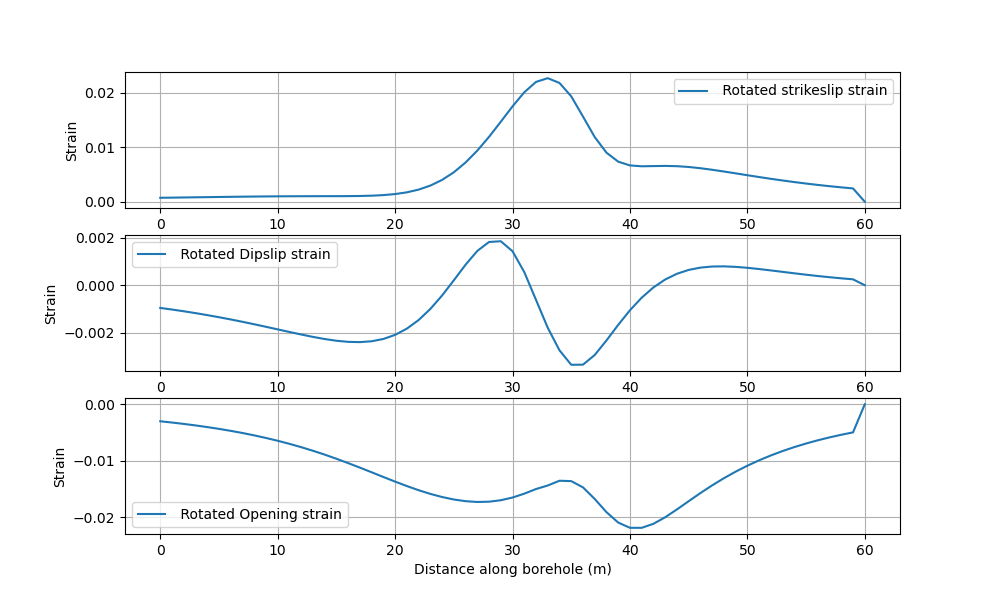

In [12]:

# We want to plot the strains as a function of the distance along the cable (rather than 
# as the distance along one of the coordinate axes)
distance_along_line = np.sqrt( (obsx-obsx[0])**2 + (obsy-obsy[0])**2 + (obsz-obsz[0])**2)
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(distance_along_line,strain_grid_new1[:,0],label=' Rotated strikeslip strain')
# ax[0].plot(distance_along_line,strain_grid1[:,0],label='Modeled Exx Strain')
ax[0].set_xlabel('Distance along borehole (m)')
ax[0].set_ylabel('Strain')
ax[0].grid()
ax[0].legend()
ax[1].plot(distance_along_line,strain_grid_new2[:,0],label=' Rotated Dipslip strain')
# ax[0].plot(distance_along_line,strain_grid2[:,0],label='Modeled Exx Strain')
ax[1].set_xlabel('Distance along borehole (m)')
ax[1].set_ylabel('Strain')
ax[1].grid()
ax[1].legend()
ax[2].plot(distance_along_line,strain_grid_new3[:,0],label=' Rotated Opening strain')
# ax[0].plot(distance_along_line,strain_grid2[:,0],label='Modeled Exx Strain')
ax[2].set_xlabel('Distance along borehole (m)')
ax[2].set_ylabel('Strain')
ax[2].grid()
ax[2].legend()

In [13]:
df_fullT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDT/maystim22_26_combined_full')
dasScaler = 116.0
df_fullT = df_fullT.multiply(dasScaler)
df_fullT = detrend(df_fullT,axis=0,type='linear')

wn     = ['OT','OB','PST','PSB','PDB','PDT']
nfile_list = sorted(os.walk('/data1/parker/EGS_iDAS'))
nfile_list = nfile_list[1:]
#file_list = file_list[1:]
nfile_list = [group[2] for group in nfile_list]
nfile_list = [item for sublist in nfile_list for item in sublist]
# [file_list.append(f) for f in nfile_list]
fd = [name.split("_") for name in nfile_list]
fl = [fd[file][2].split(".") for file in range(len(fd))]
fl = [el[0] for el in fl]
DASdates = [datetime.strptime(d,'%y%m%d%H%M%S') for d in sorted(fl)]
# these are files that get skipped during the low pass filtering process and so the dates need to be removed 
ind2rem = [0, 90, 91, 257, 258, 1571, 1572, 3082, 3083, 5085, 5086, 5599, 5600, 5961, 5962, 7623, 7624, 8841, 8842, 9562]
# remove in reverse so that the indices remain in the correct order for removal
for index in sorted(ind2rem,reverse=True):
    del DASdates[index]

directory = sorted(os.walk('/home/spri902/mayCASSM'))
CASSMdates = [datetime.strptime(d,'%Y%m%d%H%M%S') for d in sorted(directory[0][1])]
chansT=np.linspace(0,df_fullT.shape[1] - 1,df_fullT.shape[1]).astype(int)
stimbeg = [96, 224, 352, 472, 507]
stimfin = [106, 232, 368, 475, 512]
stimbegLines = itemgetter(*stimbeg)(CASSMdates)
stimfinLines = itemgetter(*stimfin)(CASSMdates)

In [14]:
dasdnums = mdates.date2num(DASdates)
cassmdnums = mdates.date2num(CASSMdates)
DASintT = resample(df_fullT,len(cassmdnums[:-2]))
dasd = pd.date_range(start=DASdates[0],end=DASdates[-1],periods=len(cassmdnums[:-2]))
df_strain_intT = cumulative_trapezoid(DASintT,axis=0,initial=0)
df_strainT = cumulative_trapezoid(df_fullT,axis=0,initial=0)


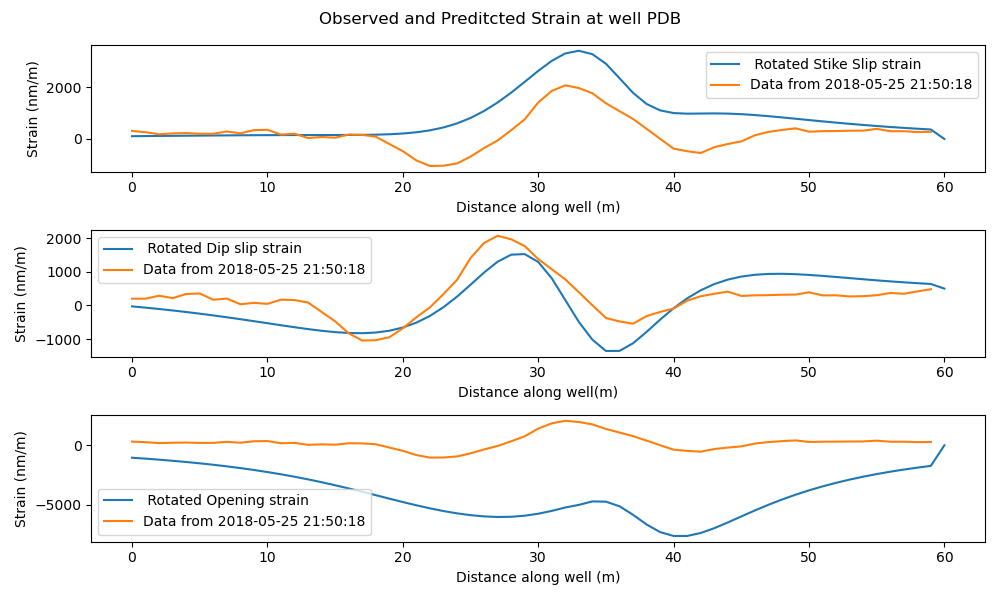

In [15]:
fig, ax = plt.subplots(3,1,figsize=(10,6))
fig.suptitle('Observed and Preditcted Strain at well PDB')
ax[0].plot(distance_along_line,strain_grid_new1[:,0]*150000,label=' Rotated Stike Slip strain')
ax[0].plot(chansT[:60],df_strainT[8565,:60],label=f'Data from {DASdates[8565]}')
# ax[0].plot(chansT[:60],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[0].set_xlabel('Distance along well (m)')
ax[0].set_ylabel('Strain (nm/m)')

ax[0].legend()

ax[1].plot(distance_along_line,(strain_grid_new2[:,0]*550000)+500,label=' Rotated Dip slip strain')
ax[1].plot(chansT[:60],df_strainT[8565,5:65],label=f'Data from {DASdates[8565]}')
# ax[1].plot(chansT[4:64],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[1].set_xlabel('Distance along well(m)')
ax[1].set_ylabel('Strain (nm/m)')

ax[1].legend()

ax[2].plot(distance_along_line,(strain_grid_new3[:,0]*350000),label=' Rotated Opening strain')
ax[2].plot(chansT[:60],df_strainT[8565,0:60],label=f'Data from {DASdates[8565]}')
# ax[2].plot(chansT[:60],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[2].set_xlabel('Distance along well (m)')
ax[2].set_ylabel('Strain (nm/m)')

ax[2].legend()
fig.tight_layout()


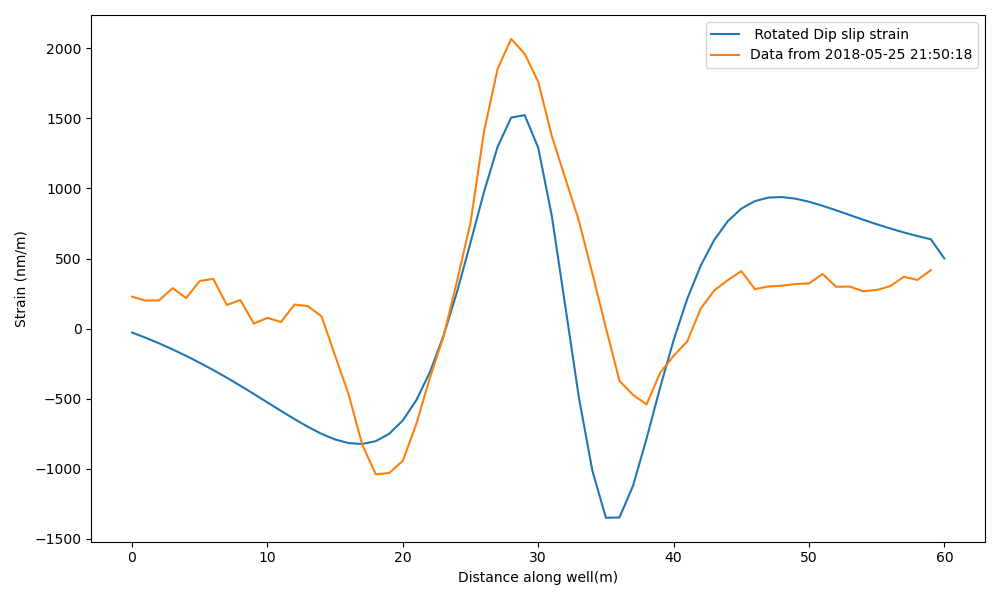

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(distance_along_line,(strain_grid_new2[:,0]*550000)+500,label=' Rotated Dip slip strain')
# ax.plot(chansT[:60],df_strainT[8444,5:65],label=f'Data from {DASdates[8444]}')
ax.plot(chansT[:60],df_strainT[8565,4:64],label=f'Data from {DASdates[8565]}')
# ax.plot(chansT[:60],df_strainT[7865,5:65],label=f'Data from {DASdates[7865]}')
ax.set_xlabel('Distance along well(m)')
ax.set_ylabel('Strain (nm/m)')

ax.legend()
fig.tight_layout()

In [28]:
# norms=np.zeros(len(obsx)-1)

# def get_normals(pnts):
#     diff=[]
#     for i in range(len(pnts)-1):
#         x0, y0, z0, xa, ya, za = pts[i,0], pts[i,1], pts[i,2], pts[i+1,0], pts[i+1,1], pts[i+1,2]
#         dx, dy,dz = xa-x0, ya-y0,za-z0
#         norms[i] = np.linalg.norm([pts[i+1,:]-pts[i,:]])
#         dx = dx/norms[i]
#         dy = dy/norms[i]
#         dz = dz/norms[i]
#         diff.append([dx,dy,dz])
#     return diff,norms
#         # ax.plot((x0,x0-dy),(y0,y0+dx),(z0,z0-dz))
# # fig=plt.figure()
# # ax = fig.add_subplot(projection='3d')
# # ax.scatter(obsx,obsy,obsz)
# diff = get_normals(pts)


In [36]:
from scipy.linalg import lstsq
# G = np.vstack([np.zeros_like(strain_grid_new1[:-1,0]),strain_grid_new2[:-1,0],np.zeros_like(strain_grid_new3[:-1,0])]).T
G = np.vstack([strain_grid_new1[:-1,0],strain_grid_new2[:-1,0],strain_grid_new3[:-1,0]]).T
# G = strain_grid_new2[:-1,0]
d = df_strainT[8565,0:60]
# d = df_strainT[8444,0:60]
m = lstsq(G,d)
print(m[0])

[113777.18950061 -77734.61532764  46873.1856779 ]


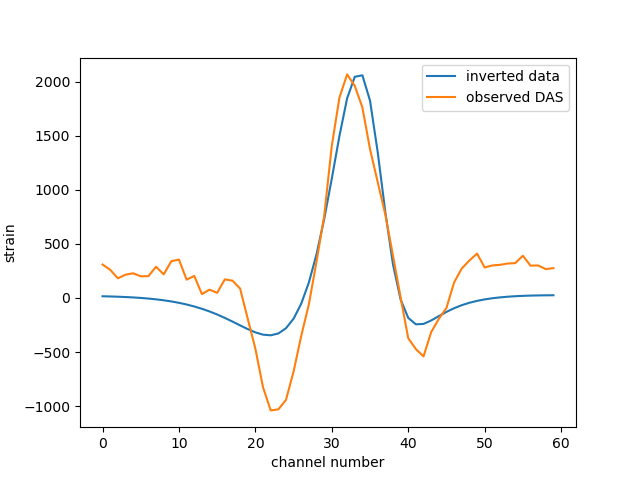

In [37]:
plt.figure()
plt.plot(np.dot(G,m[0]),label='inverted data')
plt.plot(d,label='observed DAS')
plt.xlabel('channel number')
plt.ylabel('strain')
plt.legend()

In [83]:
U,S,Vt = svd(G,full_matrices=False,lapack_driver='gesvd')
Up = U[:,0:3] # Keep 3 columns of U bc p = 3
Sp = S[0:3] # Keep 1st 3 singular values
Sp = np.diag(Sp) # rebuild S into a matrix
Vp = Vt[0:3,:] # Keep p rows of Vt
gInv = np.dot(np.dot(Vp.T,np.linalg.inv(Sp)),Up.T) # do the generalized inverse
mInv = np.dot(gInv,d) # estimate model parameters 
covd = np.diag(np.dot(d**2,np.eye(len(d)))) # Turn covd back into a matrix
covm = np.dot(gInv,np.dot(covd.T,gInv.T))
dp   = np.dot(G,mInv)
l2norm = np.sqrt(np.sum((d - dp)**2))

In [84]:

print(f'Model parameters estimated with SVD (nm/m):\n {mInv}')

Model parameters estimated with SVD (nm/m):
 [113777.18950061 -77734.61532764  46873.1856779 ]


In [86]:
np.sqrt(np.diag(covm))

array([38492.42772865, 68384.42832406, 16203.65519661])